In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, defaultdict, Counter
import logging
import warnings
import random
from typing import Tuple, Dict, List, Optional
import math
import pickle
import os
import platform
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Constants
FLOW_FEATURE_DIM = 81  # Only flow features used for training/prediction
ACTION_DIM = 2         # Normal, DDoS
HIDDEN_DIM = 256
LEARNING_RATE = 0.1
GAMMA = 0.99
LAMBDA = 0.95
EPSILON = 0.2
WINDOW_SIZE = 100
MAX_EPISODES = 1000
BATCH_SIZE = 64
UPDATE_EPOCHS = 5
ENTROPY_COEF = 0.1
VALUE_COEF = 0.5
MAX_GRAD_NORM = 0.5

# EWMA parameters for adaptive thresholds
SHORT_SPAN = 10
LONG_SPAN = 100
VAR_SPAN = 10
THRESHOLD_MULTIPLIER = 0.5

# Score weights for combined anomaly score
VOLUME_WEIGHT = 0.4
TEMPORAL_WEIGHT = 0.4
ENTROPY_WEIGHT = 0.2

# Enhanced early stopping parameters
EARLY_STOP_PATIENCE = 500
EARLY_STOP_WARMUP = 20
EARLY_STOP_THRESHOLD = 0.01
EARLY_STOP_MIN_IMPROVEMENT = 0.101
EARLY_STOP_LOOKBACK_WINDOW = 10
USE_VALIDATION_FOR_EARLY_STOP = False
VAL_CHECK_INTERVAL = 5
EARLY_STOP_METRIC = 'combined'  # 'combined', 'reward', 'loss'

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

class AdaptiveThresholdDetector:
    """Dynamic adaptive threshold detector using EWMA long-short method with combined scores"""
    
    def __init__(self, short_span=SHORT_SPAN, long_span=LONG_SPAN, 
                 var_span=VAR_SPAN, threshold_multiplier=THRESHOLD_MULTIPLIER):
        self.short_span = short_span
        self.long_span = long_span
        self.var_span = var_span
        self.threshold_multiplier = threshold_multiplier
        
        # History tracking with limited memory
        self.volume_history = deque(maxlen=5000)
        self.temporal_history = deque(maxlen=5000)
        self.entropy_history = deque(maxlen=5000)
        self.combined_history = deque(maxlen=5000)
        
        self.volume_thresholds = deque(maxlen=5000)
        self.temporal_thresholds = deque(maxlen=5000)
        self.entropy_thresholds = deque(maxlen=5000)
        self.combined_thresholds = deque(maxlen=5000)
        
        self.volume_short_ewma = deque(maxlen=5000)
        self.volume_long_ewma = deque(maxlen=5000)
        self.temporal_short_ewma = deque(maxlen=5000)
        self.temporal_long_ewma = deque(maxlen=5000)
        self.entropy_short_ewma = deque(maxlen=5000)
        self.entropy_long_ewma = deque(maxlen=5000)
        self.combined_short_ewma = deque(maxlen=5000)
        self.combined_long_ewma = deque(maxlen=5000)
        
        self.recent_ddos_flags = deque(maxlen=10)
        self.persistence_window = 10
        self.persistence_threshold = 3
        
    def update_scores(self, volume_score: float, temporal_score: float, entropy_score: float):
        """Update scores and return anomaly status using combined weighted score"""
        # Store individual scores
        self.volume_history.append(volume_score)
        self.temporal_history.append(temporal_score)
        self.entropy_history.append(entropy_score)
        
        # Calculate combined weighted score
        combined_score = (volume_score * VOLUME_WEIGHT + 
                         temporal_score * TEMPORAL_WEIGHT + 
                         entropy_score * ENTROPY_WEIGHT)
        self.combined_history.append(combined_score)
        
        # Calculate anomalies for all scores
        vol_anomaly, vol_thresh, vol_short, vol_long = self._calculate_anomaly(self.volume_history)
        temp_anomaly, temp_thresh, temp_short, temp_long = self._calculate_anomaly(self.temporal_history)
        ent_anomaly, ent_thresh, ent_short, ent_long = self._calculate_anomaly(self.entropy_history,is_en=True)
        comb_anomaly, comb_thresh, comb_short, comb_long = self._calculate_anomaly(self.combined_history)
        
        # Store thresholds and EWMA values for visualization
        self.volume_thresholds.append(vol_thresh)
        self.temporal_thresholds.append(temp_thresh)
        self.entropy_thresholds.append(ent_thresh)
        self.combined_thresholds.append(comb_thresh)
        
        self.volume_short_ewma.append(vol_short)
        self.volume_long_ewma.append(vol_long)
        self.temporal_short_ewma.append(temp_short)
        self.temporal_long_ewma.append(temp_long)
        self.entropy_short_ewma.append(ent_short)
        self.entropy_long_ewma.append(ent_long)
        self.combined_short_ewma.append(comb_short)
        self.combined_long_ewma.append(comb_long)
        
        # Use combined anomaly as primary decision
        is_ddos_raw = comb_anomaly
        
        # Persistence check
        self.recent_ddos_flags.append(int(is_ddos_raw))
        if len(self.recent_ddos_flags) > self.persistence_window:
            self.recent_ddos_flags.popleft()

        persistent_ddos = sum(self.recent_ddos_flags) >= self.persistence_threshold
        return int(persistent_ddos), vol_anomaly, temp_anomaly, ent_anomaly, comb_anomaly
    
    def _calculate_anomaly(self, history: deque,is_en=False) -> Tuple[bool, float, float, float]:
        """Calculate anomaly using EWMA long-short method and return threshold info"""
        if len(history) < max(self.short_span, self.long_span, self.var_span):
            return False, 0.0, 0.0, 0.0  # Not enough data
        
        # Convert to pandas Series for EWMA calculations
        series = pd.Series(history)
        
        # EWMA Smoothing
        short_ewma = series.ewm(span=self.short_span, adjust=False).mean().iloc[-1]
        long_ewma = series.ewm(span=self.long_span, adjust=False).mean().iloc[-1]
        
        # Difference and relative difference
        ewma_diff = short_ewma - long_ewma
        rel_diff = ewma_diff / (abs(long_ewma) + 1e-6)
        
        # Compute volatility (EWMA of squared deviation from long_ewma)
        sq_deviation = (series - long_ewma) ** 2
        ewma_var = sq_deviation.ewm(span=self.var_span, adjust=False).mean().iloc[-1]
        ewma_std = math.sqrt(ewma_var)
        
        # Dynamic threshold
        dynamic_thresh = self.threshold_multiplier * ewma_std / (abs(long_ewma) + 1e-6)
        if is_en:
            return abs(rel_diff) > dynamic_thresh, dynamic_thresh, short_ewma, long_ewma
        
        # Anomaly detected if relative difference exceeds threshold
        return rel_diff > dynamic_thresh, dynamic_thresh, short_ewma, long_ewma
    
    def plot_thresholds(self, save_path: str = None):
        """Plot the dynamic thresholds and EWMA values for all scores"""
        fig, axes = plt.subplots(4, 1, figsize=(12, 12))
        plt.subplots_adjust(hspace=0.5)
        
        # Volume score plot
        axes[0].plot(self.volume_history, label='Volume Score', alpha=0.6)
        axes[0].plot(self.volume_short_ewma, label='Short EWMA', linestyle='--')
        axes[0].plot(self.volume_long_ewma, label='Long EWMA', linestyle='--')
        axes[0].plot(np.abs(np.array(self.volume_short_ewma) - np.array(self.volume_long_ewma)) / 
                (np.abs(np.array(self.volume_long_ewma)) + 1e-6),
                label='Relative Difference', color='purple', alpha=0.6)
        axes[0].plot(self.volume_thresholds, label='Dynamic Threshold', color='red')
        axes[0].set_title('Volume Score Adaptive Threshold')
        axes[0].set_xlabel('Time Step')
        axes[0].set_ylabel('Score')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Temporal score plot
        axes[1].plot(self.temporal_history, label='Temporal Score', alpha=0.6)
        axes[1].plot(self.temporal_short_ewma, label='Short EWMA', linestyle='--')
        axes[1].plot(self.temporal_long_ewma, label='Long EWMA', linestyle='--')
        axes[1].plot(np.abs(np.array(self.temporal_short_ewma) - np.array(self.temporal_long_ewma)) / 
                (np.abs(np.array(self.temporal_long_ewma)) + 1e-6),
                label='Relative Difference', color='purple', alpha=0.6)
        axes[1].plot(self.temporal_thresholds, label='Dynamic Threshold', color='red')
        axes[1].set_title('Temporal Score Adaptive Threshold')
        axes[1].set_xlabel('Time Step')
        axes[1].set_ylabel('Score')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Entropy score plot
        axes[2].plot(self.entropy_history, label='Entropy Score', alpha=0.6)
        axes[2].plot(self.entropy_short_ewma, label='Short EWMA', linestyle='--')
        axes[2].plot(self.entropy_long_ewma, label='Long EWMA', linestyle='--')
        axes[2].plot(np.abs(np.array(self.entropy_short_ewma) - np.array(self.entropy_long_ewma)) / 
                (np.abs(np.array(self.entropy_long_ewma)) + 1e-6),
                label='Relative Difference', color='purple', alpha=0.6)
        axes[2].plot(self.entropy_thresholds, label='Dynamic Threshold', color='red')
        axes[2].set_title('Entropy Score Adaptive Threshold')
        axes[2].set_xlabel('Time Step')
        axes[2].set_ylabel('Score')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        
        # Combined score plot
        axes[3].plot(self.combined_history, label='Combined Score', alpha=0.6)
        axes[3].plot(self.combined_short_ewma, label='Short EWMA', linestyle='--')
        axes[3].plot(self.combined_long_ewma, label='Long EWMA', linestyle='--')
        axes[3].plot(np.abs(np.array(self.combined_short_ewma) - np.array(self.combined_long_ewma)) / 
                (np.abs(np.array(self.combined_long_ewma)) + 1e-6),
                label='Relative Difference', color='purple', alpha=0.6)
        axes[3].plot(self.combined_thresholds, label='Dynamic Threshold', color='red')
        axes[3].set_title('Combined Score Adaptive Threshold')
        axes[3].set_xlabel('Time Step')
        axes[3].set_ylabel('Score')
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Threshold plots saved to {save_path}")
        
        plt.show()

class EnhancedDDoSEnvironment:
    """Enhanced DDoS detection environment with adaptive thresholds and combined scores"""
    
    def __init__(self, data, window_size=100, validation_split=0.2):
        # Data should contain: 81 flow features + volume_score + temporal_score + entropy_score
        self.full_data = self._validate_and_preprocess_data(data)
        
        # Separate flow features from anomaly scores
        self.flow_features = self.full_data[:, :FLOW_FEATURE_DIM]  # Only flow features for training
        self.anomaly_scores = self.full_data[:, FLOW_FEATURE_DIM:]  # Volume, temporal and entropy scores
        
        self.window_size = window_size
        self.current_step = 0
        self.max_steps = len(self.flow_features) - window_size
        self.threshold_detector = AdaptiveThresholdDetector()
        
        # Split data for validation during training
        split_idx = int(len(self.flow_features) * (1 - validation_split))
        self.train_flow = self.flow_features[:split_idx]
        self.train_scores = self.anomaly_scores[:split_idx]
        self.val_flow = self.flow_features[split_idx:]
        self.val_scores = self.anomaly_scores[split_idx:]
        
        # Episode tracking
        self.episode_rewards = []
        self.episode_actions = []
        self.episode_metrics = {
            'true_positives': [],
            'true_negatives': [],
            'false_positives': [],
            'false_negatives': []
        }
        
        logger.info(f"Environment initialized with {len(self.flow_features)} samples")
    
    def _validate_and_preprocess_data(self, data):
        """Validate and preprocess input data"""
        if not isinstance(data, np.ndarray):
            data = np.array(data, dtype=np.float32)
        
        # Data should contain: 80 flow features + volume_score + temporal_score + entropy_score
        if data.shape[1] != FLOW_FEATURE_DIM + 3:
            raise ValueError(f"Expected {FLOW_FEATURE_DIM + 3} features, got {data.shape[1]}")
        
        # Handle missing values
        data = np.nan_to_num(data, nan=0.0, posinf=1e6, neginf=-1e6)
        
        # Clip extreme values
        data = np.clip(data, -1e6, 1e6)
        
        return data
    
    def reset(self, use_validation=False):
        """Reset environment"""
        if use_validation:
            flow_data = self.val_flow
            score_data = self.val_scores
        else:
            flow_data = self.train_flow
            score_data = self.train_scores
        
        if len(flow_data) < self.window_size:
            flow_data = self.flow_features
            score_data = self.anomaly_scores
        
        self.current_step = np.random.randint(0, max(1, len(flow_data) - self.window_size))
        self.episode_rewards = []
        self.episode_actions = []
        
        # Reset threshold detector for new episode
        self.threshold_detector = AdaptiveThresholdDetector()
        
        # Reset metrics
        self.episode_metrics = {
            'true_positives': [],
            'true_negatives': [],
            'false_positives': [],
            'false_negatives': []
        }
        
        # Return only flow features (state)
        return flow_data[self.current_step]
    
    def step(self, action):
        """Execute action and return next state (flow features only), reward, done"""
        # Get current flow features (state)
        current_state = self._get_current_flow_features()
        
        # Get current anomaly scores (only for reward calculation)
        volume_score, temporal_score, entropy_score = self._get_current_anomaly_scores()
        
        # Get ground truth from adaptive threshold detector (only for reward)
        label, vol_anomaly, temp_anomaly, ent_anomaly, comb_anomaly = self.threshold_detector.update_scores(
            volume_score, temporal_score, entropy_score
        )
        
        # Calculate reward based on adaptive threshold detection
        reward = self._calculate_reward(action, label)
        
        # Update confusion matrix metrics
        self._update_confusion_metrics(action, label)
        
        # Track episode data
        self.episode_rewards.append(reward)
        self.episode_actions.append(action)
        
        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.flow_features) - 1
        
        # Get next state (flow features only)
        next_state = self._get_current_flow_features() if not done else np.zeros(FLOW_FEATURE_DIM)
        
        return next_state, reward, done, {
            'vol_anomaly': vol_anomaly, 
            'temp_anomaly': temp_anomaly,
            'ent_anomaly': ent_anomaly,
            'comb_anomaly': comb_anomaly,
            'label': label
        }
    
    def _update_confusion_metrics(self, action, label):
        """Update confusion matrix metrics"""
        if action == 1 and label == 1:  # True Positive
            self.episode_metrics['true_positives'].append(1)
        elif action == 0 and label == 0:  # True Negative
            self.episode_metrics['true_negatives'].append(1)
        elif action == 1 and label == 0:  # False Positive
            self.episode_metrics['false_positives'].append(1)
        elif action == 0 and label == 1:  # False Negative
            self.episode_metrics['false_negatives'].append(1)
    
    def get_confusion_matrix(self):
        """Return the current confusion matrix"""
        tp = sum(self.episode_metrics['true_positives'])
        tn = sum(self.episode_metrics['true_negatives'])
        fp = sum(self.episode_metrics['false_positives'])
        fn = sum(self.episode_metrics['false_negatives'])
        
        return np.array([[tn, fp], [fn, tp]])
    
    def plot_confusion_matrix(self, save_path: str = None):
        """Plot the confusion matrix"""
        cm = self.get_confusion_matrix()
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Normal', 'DDoS'],
                    yticklabels=['Normal', 'DDoS'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Confusion matrix saved to {save_path}")
        
        plt.show()
    
    def _get_current_flow_features(self):
        """Get current flow features (state)"""
        if self.current_step >= len(self.flow_features) - 1:
            self.current_step = 0
        
        if self.current_step < len(self.train_flow):
            return self.train_flow[self.current_step]
        else:
            return self.val_flow[self.current_step - len(self.train_flow)]
    
    def _get_current_anomaly_scores(self):
        """Get current volume, temporal and entropy scores (only for reward calculation)"""
        if self.current_step >= len(self.anomaly_scores) - 1:
            self.current_step = 0
        
        if self.current_step < len(self.train_scores):
            return self.train_scores[self.current_step]
        else:
            return self.val_scores[self.current_step - len(self.train_scores)]
    
    def _calculate_reward(self, action, label):
        
        """Calculate reward based on adaptive threshold detection"""
        # True Positive: Correctly detected DDoS
        if action == 1 and label == 1:
            return 1.20
        # True Negative: Correctly identified normal traffic
        elif action == 0 and label == 0:
            return 0.50
        # False Positive: Normal traffic classified as DDoS
        elif action == 1 and label == 0:
            return -1.0
        # False Negative: DDoS traffic classified as normal (most severe)
        else:  # action == 0 and label == 1
            return -2.0
    
    def _calculate_episode_bonus(self):
        """Calculate bonus/penalty at episode end with improved balance"""
        if len(self.episode_actions) == 0:
            return 0.0
        
        ddos_ratio = sum(self.episode_actions) / len(self.episode_actions)
        
        # Adjusted thresholds to encourage more DDoS detection
        if 0.15 <= ddos_ratio <= 0.50:
            if 0.20 <= ddos_ratio <= 0.35:
                return 0.3  # Sweet spot bonus
            else:
                return 0.1
        elif ddos_ratio > 0.70:
            return -0.9
        elif ddos_ratio < 0.10:
            return -0.8
        elif ddos_ratio < 0.05:
            return -1.2
        
        return 0.0

class ImprovedPPONetwork(nn.Module):
    """Improved PPO network that only processes flow features"""
    
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super().__init__()
        
        # Shared feature extraction layers (only flow features)
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Policy head
        self.policy_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim)
        )
        
        # Value head
        self.value_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.orthogonal_(module.weight, gain=np.sqrt(2))
            torch.nn.init.constant_(module.bias, 0)
    
    def forward(self, state):
        # Only processes flow features
        shared_features = self.shared_layers(state)
        
        # Policy output (action logits)
        action_logits = self.policy_head(shared_features)
        
        # Value output
        value = self.value_head(shared_features)
        
        return action_logits, value.squeeze(-1)

class EnhancedPPOAgent:
    """Enhanced PPO agent with advanced training features"""
    
    def __init__(self, state_dim, action_dim, hidden_dim=256, learning_rate=LEARNING_RATE):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"Using device: {self.device}")
        
        # Networks (only processes flow features)
        self.policy = ImprovedPPONetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam([
            
            {'params': self.policy.shared_layers.parameters(), 'lr': LEARNING_RATE},
            {'params': self.policy.policy_head.parameters(), 'lr': 0.001},
            {'params': self.policy.value_head.parameters(), 'lr': LEARNING_RATE}
        ], eps=1e-5)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.95)
        
        # Training parameters
        self.gamma = GAMMA
        self.lambda_gae = LAMBDA
        self.epsilon = EPSILON
        self.entropy_coef = ENTROPY_COEF
        self.value_coef = VALUE_COEF
        
        # Enhanced training history
        self.training_metrics = defaultdict(list)
        self.validation_metrics = defaultdict(list)
        self.best_reward = -float('inf')
        self.best_val_reward = -float('inf')
        self.best_loss = float('inf')
        self.best_val_loss = float('inf')
        self.early_stop_patience = EARLY_STOP_PATIENCE
        self.early_stop_threshold = EARLY_STOP_THRESHOLD
        self.episodes_without_improvement = 0
        self.best_model_state = None
        self.best_val_model_state = None
        self.early_stop_patience = EARLY_STOP_PATIENCE
        self.early_stop_warmup = EARLY_STOP_WARMUP
        self.early_stop_min_improvement = EARLY_STOP_MIN_IMPROVEMENT
        self.early_stop_metric = EARLY_STOP_METRIC  # 'combined', 'reward', 'loss'
        
        # History tracking
        self.reward_history = deque(maxlen=EARLY_STOP_LOOKBACK_WINDOW)
        self.val_reward_history = deque(maxlen=EARLY_STOP_LOOKBACK_WINDOW)
        self.loss_history = deque(maxlen=EARLY_STOP_LOOKBACK_WINDOW)
        self.val_loss_history = deque(maxlen=EARLY_STOP_LOOKBACK_WINDOW)
        
        # Confusion matrix history
        self.confusion_matrices = []
        
        # Experience buffer (only stores flow features)
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
    
    def get_action_and_value(self, state):
        """Get action and value from policy (using only flow features)"""
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).to(self.device)
        
        if state.dim() == 1:
            state = state.unsqueeze(0)
        
        with torch.no_grad():
            action_logits, value = self.policy(state)
            action_probs = F.softmax(action_logits, dim=-1)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
        
        return action.item(), log_prob.item(), value.item()
    
    def act(self, state):
        """Get action for given state (for inference, using only flow features)"""
        action, log_prob, value = self.get_action_and_value(state)
        return action, log_prob, value
    
    def store_transition(self, state, action, reward, value, log_prob, done):
        """Store transition in buffer (only flow features)"""
        # Convert to numpy arrays to save memory
        if isinstance(state, torch.Tensor):
            state = state.cpu().numpy()
        
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)
    
    def compute_gae(self, next_value):
        """Compute Generalized Advantage Estimation"""
        advantages = []
        gae = 0
        
        for step in reversed(range(len(self.rewards))):
            if step == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[step]
                next_value_step = next_value
            else:
                next_non_terminal = 1.0 - self.dones[step]
                next_value_step = self.values[step + 1]
            
            delta = self.rewards[step] + self.gamma * next_value_step * next_non_terminal - self.values[step]
            gae = delta + self.gamma * self.lambda_gae * next_non_terminal * gae
            advantages.insert(0, gae)
        
        returns = [adv + val for adv, val in zip(advantages, self.values)]
        
        return advantages, returns
    
    def update_policy(self):
        """Update policy using PPO (only uses flow features)"""
        if len(self.states) == 0:
            return
        
        # Compute next value (assuming episode ended)
        next_value = 0.0
        advantages, returns = self.compute_gae(next_value)
        
        # Convert to tensors (only flow features)
        states = torch.FloatTensor(np.array(self.states)).to(self.device)
        actions = torch.LongTensor(self.actions).to(self.device)
        old_log_probs = torch.FloatTensor(self.log_probs).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # PPO update
        total_losses = []
        for _ in range(UPDATE_EPOCHS):
            # Forward pass (only flow features)
            action_logits, values = self.policy(states)
            action_probs = F.softmax(action_logits, dim=-1)
            action_dist = torch.distributions.Categorical(action_probs)
            
            new_log_probs = action_dist.log_prob(actions)
            entropy = action_dist.entropy().mean()
            
            # Ratio for PPO
            ratio = torch.exp(new_log_probs - old_log_probs)
            
            # Surrogate losses
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Value loss
            value_loss = F.mse_loss(values, returns)
            
            # Total loss
            total_loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy
            total_losses.append(total_loss.item())
            
            # Backward and optimize
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), MAX_GRAD_NORM)
            self.optimizer.step()
            
            # Store metrics
            self.training_metrics['policy_loss'].append(policy_loss.item())
            self.training_metrics['value_loss'].append(value_loss.item())
            self.training_metrics['entropy'].append(entropy.item())
            self.training_metrics['total_loss'].append(total_loss.item())
        
        # Track average loss for this update
        avg_loss = np.mean(total_losses)
        self.loss_history.append(avg_loss)
        
        # Clear buffer
        self.clear_buffer()
        
        # Update learning rate
        self.scheduler.step()
    
    def clear_buffer(self):
        """Clear experience buffer"""
        del self.states[:]
        del self.actions[:]
        del self.rewards[:]
        del self.values[:]
        del self.log_probs[:]
        del self.dones[:]
        
        # Force garbage collection
        import gc
        gc.collect()

    def check_early_stopping(self, episode_reward: float, val_reward: float = None, 
                           episode: int = 0, val_loss: float = None) -> bool:
        """
        Simplified and more reliable early stopping strategy.
        
        Args:
            episode_reward: Current episode reward
            val_reward: Current validation reward (optional)
            episode: Current episode number
            val_loss: Current validation loss (optional)
            
        Returns:
            bool: True if training should stop, False otherwise
        """
        # Skip early stopping checks during warmup period
        if episode < self.early_stop_warmup:
            return False
        
        # Update histories
        self.reward_history.append(episode_reward)
        if val_reward is not None:
            self.val_reward_history.append(val_reward)
        if val_loss is not None:
            self.val_loss_history.append(val_loss)
        
        # Determine if we've improved based on selected metric
        improved = False
        
        if self.early_stop_metric == 'reward':
            # Reward-based improvement (training or validation)
            if episode_reward > self.best_reward + self.early_stop_min_improvement:
                improved = True
                self.best_reward = episode_reward
                
            if (USE_VALIDATION_FOR_EARLY_STOP and val_reward is not None and 
                val_reward > self.best_val_reward + self.early_stop_min_improvement):
                improved = True
                self.best_val_reward = val_reward
                
        elif self.early_stop_metric == 'loss':
            # Loss-based improvement (training or validation)
            if len(self.loss_history) > 0 and self.loss_history[-1] < self.best_loss - self.early_stop_min_improvement:
                improved = True
                self.best_loss = self.loss_history[-1]
                
            if (USE_VALIDATION_FOR_EARLY_STOP and val_loss is not None and 
                val_loss < self.best_val_loss - self.early_stop_min_improvement):
                improved = True
                self.best_val_loss = val_loss
                
        else:  # 'combined' metric
            # Combined reward and loss improvement
            reward_improved = (episode_reward > self.best_reward + self.early_stop_min_improvement)
            loss_improved = (len(self.loss_history) > 0 and 
                            self.loss_history[-1] < self.best_loss - self.early_stop_min_improvement)
            
            if USE_VALIDATION_FOR_EARLY_STOP:
                val_reward_improved = (val_reward is not None and 
                                      val_reward > self.best_val_reward + self.early_stop_min_improvement)
                val_loss_improved = (val_loss is not None and 
                                     val_loss < self.best_val_loss - self.early_stop_min_improvement)
                improved = (reward_improved or loss_improved) and (val_reward_improved or val_loss_improved)
            else:
                improved = reward_improved or loss_improved
                
            # Update best metrics
            if reward_improved:
                self.best_reward = episode_reward
            if loss_improved and len(self.loss_history) > 0:
                self.best_loss = self.loss_history[-1]
            if val_reward_improved and val_reward is not None:
                self.best_val_reward = val_reward
            if val_loss_improved and val_loss is not None:
                self.best_val_loss = val_loss
        
        # Save best model states
        if improved:
            self.episodes_without_improvement = 0
            self.best_model_state = {
                'model_state_dict': self.policy.state_dict().copy(),
                'optimizer_state_dict': self.optimizer.state_dict().copy(),
                'scheduler_state_dict': self.scheduler.state_dict().copy(),
                'episode': episode,
                'reward': episode_reward,
                'loss': self.loss_history[-1] if len(self.loss_history) > 0 else float('inf')
            }
            
            if USE_VALIDATION_FOR_EARLY_STOP and val_reward is not None:
                self.best_val_model_state = {
                    'model_state_dict': self.policy.state_dict().copy(),
                    'optimizer_state_dict': self.optimizer.state_dict().copy(),
                    'scheduler_state_dict': self.scheduler.state_dict().copy(),
                    'episode': episode,
                    'reward': val_reward,
                    'loss': val_loss if val_loss is not None else float('inf')
                }
        else:
            self.episodes_without_improvement += 1
        
        # Check if we should stop
        if self.episodes_without_improvement >= self.early_stop_patience:
            logger.info(f"\nEarly stopping triggered at episode {episode}")
            logger.info(f"Best training reward: {self.best_reward:.2f}")
            if USE_VALIDATION_FOR_EARLY_STOP and val_reward is not None:
                logger.info(f"Best validation reward: {self.best_val_reward:.2f}")
            
            # Restore best model
            if USE_VALIDATION_FOR_EARLY_STOP and self.best_val_model_state is not None:
                self.policy.load_state_dict(self.best_val_model_state['model_state_dict'])
                self.optimizer.load_state_dict(self.best_val_model_state['optimizer_state_dict'])
                self.scheduler.load_state_dict(self.best_val_model_state['scheduler_state_dict'])
                logger.info(f"Restored best validation model from episode {self.best_val_model_state['episode']}")
            elif self.best_model_state is not None:
                self.policy.load_state_dict(self.best_model_state['model_state_dict'])
                self.optimizer.load_state_dict(self.best_model_state['optimizer_state_dict'])
                self.scheduler.load_state_dict(self.best_model_state['scheduler_state_dict'])
                logger.info(f"Restored best training model from episode {self.best_model_state['episode']}")
            
            return True
        
        return False
    
    def run_validation(self, env):
        """Run validation episode and return average reward and loss"""
        total_reward = 0
        total_loss = 0
        val_steps = 0
        state = env.reset(use_validation=True)
        done = False
        step_count = 0
        
        val_states = []
        val_actions = []
        val_rewards = []
        val_values = []
        val_log_probs = []
        val_dones = []
        
        # Collect validation data
        while not done and step_count < 10000:
            action, log_prob, value = self.get_action_and_value(state)
            next_state, reward, done, _ = env.step(action)
            
            val_states.append(state)
            val_actions.append(action)
            val_rewards.append(reward)
            val_values.append(value)
            val_log_probs.append(log_prob)
            val_dones.append(done)
            
            total_reward += reward
            step_count += 1
            state = next_state
        
        # Store confusion matrix for this validation run
        self.confusion_matrices.append(env.get_confusion_matrix())
        
        # Calculate validation loss if we collected any data
        if len(val_states) > 0:
            # Convert to tensors
            states = torch.FloatTensor(np.array(val_states)).to(self.device)
            actions = torch.LongTensor(val_actions).to(self.device)
            rewards = torch.FloatTensor(val_rewards).to(self.device)
            values = torch.FloatTensor(val_values).to(self.device)
            log_probs = torch.FloatTensor(val_log_probs).to(self.device)
            dones = torch.FloatTensor(val_dones).to(self.device)
            
            # Compute GAE
            with torch.no_grad():
                next_value = 0.0  # Assuming episode ended
                advantages = torch.zeros_like(rewards).to(self.device)
                lastgaelam = 0
                
                # Calculate advantages in reverse order
                for t in reversed(range(len(rewards))):
                    if t == len(rewards) - 1:
                        nextnonterminal = 1.0 - dones[t]
                        nextvalues = next_value
                    else:
                        nextnonterminal = 1.0 - dones[t]
                        nextvalues = values[t+1]
                    delta = rewards[t] + self.gamma * nextvalues * nextnonterminal - values[t]
                    advantages[t] = lastgaelam = delta + self.gamma * self.lambda_gae * nextnonterminal * lastgaelam
                
                returns = advantages + values
                
                # Normalize advantages
                advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
                # Get current policy's action probabilities
                action_logits, current_values = self.policy(states)
                action_probs = F.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(action_probs)
                
                # Calculate new log probs and entropy
                new_log_probs = dist.log_prob(actions)
                entropy = dist.entropy().mean()
                
                # Calculate ratio (importance sampling)
                ratio = torch.exp(new_log_probs - log_probs)
                
                # Calculate surrogate losses
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * advantages
                policy_loss = -torch.min(surr1, surr2).mean()
                
                # Value loss
                value_loss = F.mse_loss(current_values, returns)
                
                # Total loss
                total_loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy
                val_steps = len(val_states)
        
        avg_reward = total_reward / max(1, step_count)
        avg_loss = total_loss / max(1, val_steps) if val_steps > 0 else 0.0
        
        return avg_reward, avg_loss
    
    def plot_training_results(self, save_path: str = None):
        """Plot comprehensive training results"""
        try:
            fig, axes = plt.subplots(2, 2, figsize=(25, 18))
            fig.suptitle('PPO DDoS Detection Training Results', fontsize=16)
            
            # Episode rewards
            if 'episode_rewards' in self.training_metrics and len(self.training_metrics['episode_rewards']) > 0:
                axes[0, 0].plot(self.training_metrics['episode_rewards'], label='Training')
                if 'val_rewards' in self.training_metrics and len(self.training_metrics['val_rewards']) > 0:
                    axes[0, 0].plot(self.training_metrics['val_rewards'], label='Validation')
                axes[0, 0].set_title('Episode Rewards')
                axes[0, 0].set_xlabel('Episode')
                axes[0, 0].set_ylabel('Reward')
                axes[0, 0].grid(True, alpha=0.3)
                
                axes[0, 0].legend()
                
                # Add moving average
                if len(self.training_metrics['episode_rewards']) > 10:
                    window_size = min(50, len(self.training_metrics['episode_rewards']) // 10)
                    moving_avg = np.convolve(
                        self.training_metrics['episode_rewards'], 
                        np.ones(window_size)/window_size, 
                        mode='valid'
                    )
                    axes[0, 0].plot(
                        range(window_size-1, len(self.training_metrics['episode_rewards'])), 
                        moving_avg, 
                        color='red', 
                        alpha=0.7, 
                        label=f'MA({window_size})'
                    )
                    
                    axes[0, 0].legend()
            
            # Policy loss
            if 'policy_loss' in self.training_metrics and len(self.training_metrics['policy_loss']) > 0:
                axes[0, 1].plot(self.training_metrics['policy_loss'])
                axes[0, 1].set_title('Policy Loss')
                axes[0, 1].set_xlabel('Update Step')
                axes[0, 1].set_ylabel('Loss')
                

                axes[0, 1].grid(True, alpha=0.3)
            
            # Value loss
            if 'value_loss' in self.training_metrics and len(self.training_metrics['value_loss']) > 0:
                axes[1, 0].plot(self.training_metrics['value_loss'])
                axes[1, 0].set_title('Value Loss')
                axes[1, 0].set_xlabel('Update Step')
                axes[1, 0].set_ylabel('Loss')
                
                axes[1, 0].grid(True, alpha=0.3)
            
            # Entropy
            if 'entropy' in self.training_metrics and len(self.training_metrics['entropy']) > 0:
                axes[1, 1].plot(self.training_metrics['entropy'])
                axes[1, 1].set_title('Policy Entropy')
                axes[1, 1].set_xlabel('Update Step')
                axes[1, 1].set_ylabel('Entropy')
                axes[1, 1].grid(True, alpha=0.3)
                
                
            
           
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                logger.info(f"Training plots saved to {save_path}")
            
            plt.show()
            return True
        except Exception as e:
            logger.error(f"Error plotting training results: {e}")
            return False
    
    def train(self, env, max_episodes=MAX_EPISODES):
        """Train the PPO agent with enhanced early stopping"""
        start_time = datetime.now()
        
        for episode in range(max_episodes):
            state = env.reset()
            episode_reward = 0
            step_count = 0
            
            while True:
                action, log_prob, value = self.get_action_and_value(state)
                next_state, reward, done, info = env.step(action)
                
                self.store_transition(state, action, reward, value, log_prob, done)
                
                episode_reward += reward
                step_count += 1
                
                if done or step_count >= 10000:  # Max steps per episode
                    break
                
                state = next_state
            
            # Store episode reward
            self.training_metrics['episode_rewards'].append(episode_reward)
            
            # Run validation if enabled
            val_reward = None
            val_loss = None
            if USE_VALIDATION_FOR_EARLY_STOP and episode % VAL_CHECK_INTERVAL == 0:
                val_reward, val_loss = self.run_validation(env)
                self.training_metrics['val_rewards'].append(val_reward)
                self.training_metrics['val_losses'].append(val_loss)
            
            # Update policy at end of episode
            self.update_policy()
            
            # # Early stopping check
            # if self.check_early_stopping(episode_reward, val_reward, episode, val_loss):
            #     logger.info(f"\nEarly stopping triggered at episode {episode}")
            #     logger.info(f"Best training reward: {self.best_reward:.2f}")
            #     if val_reward is not None:
            #         logger.info(f"Best validation reward: {self.best_val_reward:.2f}")
            #     # break
            
            # Logging
            if episode % 20 == 0 or episode == max_episodes - 1:
                avg_reward = np.mean(self.training_metrics['episode_rewards'][-20:]) if len(self.training_metrics['episode_rewards']) >= 20 else np.mean(self.training_metrics['episode_rewards'])
                current_lr = self.scheduler.get_last_lr()[0]
                
                log_msg = f"Episode {episode:4d} | Reward: {episode_reward:6.2f} | Avg: {avg_reward:6.2f} | LR: {current_lr:.2e}"
                
                if val_reward is not None:
                    log_msg += f" | Val: {val_reward:6.2f}"
                if val_loss is not None:
                    log_msg += f" | Val Loss: {val_loss:.4f}"
                
                logger.info(log_msg)
        
        training_time = datetime.now() - start_time
        logger.info(f"\nTraining completed in {training_time}")
        logger.info(f"Final episode: {episode}")
        logger.info(f"Best training reward achieved: {self.best_reward:.2f}")
        if 'val_rewards' in self.training_metrics:
            logger.info(f"Best validation reward achieved: {max(self.training_metrics['val_rewards']):.2f}")
        
        # Plot training results
        self.plot_training_results("training_results.png")
        
        # Plot final confusion matrix
        if len(self.confusion_matrices) > 0:
            env.plot_confusion_matrix("final_confusion_matrix.png")
        
        # Plot threshold evolution
        env.threshold_detector.plot_thresholds("threshold_evolution.png")
        
        return self.training_metrics
    
    def evaluate(self, env, num_episodes=10, max_steps=1000, log_per_step=False):
        """
        Evaluate the trained agent using only flow features.
        """
        total_rewards = []
        action_counts = defaultdict(int)
        all_episode_rewards = []
        confusion_matrices = []

        for episode in range(num_episodes):
            state = env.reset(use_validation=True)
            episode_reward = 0
            step_count = 0
            episode_actions = []

            while True:
                action, _, _ = self.get_action_and_value(state)
                next_state, reward, done, _ = env.step(action)

                episode_reward += reward
                action_counts[action] += 1
                episode_actions.append(action)
                step_count += 1

                if log_per_step:
                    logger.debug(f"Ep {episode}, Step {step_count}, Action {action}, Reward {reward}")

                if done or step_count >= max_steps:
                    break

            total_rewards.append(episode_reward)
            all_episode_rewards.append({
                'episode': episode,
                'reward': episode_reward,
                'steps': step_count,
                'action_counts': dict(Counter(episode_actions))
            })
            
            # Store confusion matrix for this episode
            confusion_matrices.append(env.get_confusion_matrix())

            logger.info(f"Episode {episode}: Reward = {episode_reward:.2f}, Steps = {step_count}")

        avg_reward = np.mean(total_rewards)
        std_reward = np.std(total_rewards)

        logger.info(f"Evaluation - Average reward: {avg_reward:.3f} ± {std_reward:.3f}")
        logger.info(f"Action distribution: {dict(action_counts)}")
        
        # Plot average confusion matrix
        avg_cm = np.mean(confusion_matrices, axis=0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues', 
                    xticklabels=['Normal', 'DDoS'],
                    yticklabels=['Normal', 'DDoS'])
        plt.title('Average Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

        return avg_reward, dict(action_counts), all_episode_rewards
    
    def predict(self, state: np.ndarray, return_probs: bool = False, return_value: bool = False):
        """
        Make prediction on a single state (flow features only).
        """
        self.policy.eval()
        with torch.no_grad():
            # Convert and validate input
            if not isinstance(state, np.ndarray):
                state = np.array(state, dtype=np.float32)
            
            if state.shape != (FLOW_FEATURE_DIM,):
                raise ValueError(f"Expected state shape {(FLOW_FEATURE_DIM,)}, got {state.shape}")
            
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            
            # Get model outputs
            action_logits, value = self.policy(state_tensor)
            action_probs = F.softmax(action_logits, dim=-1)
            
            # Prepare return dictionary
            result = {
                'action': torch.argmax(action_probs).item(),
                'confidence': torch.max(action_probs).item(),
                'ddos_probability': action_probs[0,1].item()
            }
            
            if return_probs:
                result['probs'] = action_probs.squeeze().cpu().numpy()
            
            if return_value:
                result['value'] = value.item()
            
            return result
    
    def predict_batch(self, states: np.ndarray, return_values: bool = True):
        """
        Make predictions on a batch of states (flow features only).
        """
        self.policy.eval()
        with torch.no_grad():
            # Convert and validate input
            if not isinstance(states, np.ndarray):
                states = np.array(states, dtype=np.float32)
            
            if len(states.shape) != 2 or states.shape[1] != FLOW_FEATURE_DIM:
                raise ValueError(f"Expected states shape (N, {FLOW_FEATURE_DIM}), got {states.shape}")
            
            states_tensor = torch.FloatTensor(states).to(self.device)
            
            # Get model outputs
            action_logits, values = self.policy(states_tensor)
            action_probs = F.softmax(action_logits, dim=-1)
            
            # Prepare return dictionary with labels
            result = {
                'actions': torch.argmax(action_probs, dim=1).cpu().numpy(),
                'labels': ['DDoS' if a == 1 else 'Normal' for a in torch.argmax(action_probs, dim=1).cpu().numpy()],
                'confidences': torch.max(action_probs, dim=1).values.cpu().numpy(),
                'ddos_probabilities': action_probs[:, 1].cpu().numpy()
            }
            
            if return_values:
                result['values'] = values.cpu().numpy()
            
            result['probs'] = action_probs.cpu().numpy()
            
            return result
    
    def save_model(self, path: str, metadata: Optional[dict] = None, 
                   save_optimizer: bool = True, save_scheduler: bool = True):
        """
        Save the trained model to disk with cross-platform compatibility.
        """
        save_path = Path(path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        
        original_device = next(self.policy.parameters()).device
        self.policy.cpu()
        
        save_dict = {
            'policy_state_dict': self.policy.state_dict(),
            'model_config': {
                'state_dim': FLOW_FEATURE_DIM,
                'action_dim': ACTION_DIM,
                'hidden_dim': HIDDEN_DIM,
                'learning_rate': LEARNING_RATE
            },
            'training_metrics': dict(self.training_metrics),
            'best_reward': float(self.best_reward),
            'platform_info': {
                'platform': platform.system(),
                'python_version': platform.python_version(),
                'pytorch_version': torch.__version__,
                'saved_device': str(original_device)
            },
            'metadata': metadata or {}
        }
        
        if save_optimizer and hasattr(self, 'optimizer'):
            optimizer_state = self.optimizer.state_dict()
            for state in optimizer_state['state'].values():
                for k, v in state.items():
                    if torch.is_tensor(v):
                        state[k] = v.cpu()
            save_dict['optimizer_state_dict'] = optimizer_state
        
        if save_scheduler and hasattr(self, 'scheduler'):
            save_dict['scheduler_state_dict'] = self.scheduler.state_dict()
        
        try:
            torch.save(save_dict, str(save_path), 
                      _use_new_zipfile_serialization=False)
            
            self.policy.to(original_device)
            
            logger.info(f"Model successfully saved to {save_path}")
            logger.info(f"Saved from {platform.system()} on {original_device}")
            return True
            
        except Exception as e:
            self.policy.to(original_device)
            logger.error(f"Failed to save model to {save_path}: {str(e)}")
            return False
    
    @classmethod
    def load_model(cls, path: str, device: Optional[str] = None, 
                   map_location: Optional[str] = None, strict: bool = True):
        """
        Load a trained model from disk with cross-platform compatibility.
        """
        save_path = Path(path)
        if not save_path.exists():
            raise FileNotFoundError(f"Model file not found: {save_path}")
        
        if device is None or device == 'auto':
            target_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            target_device = torch.device(device)
        
        if map_location is None:
            map_location = str(target_device)
        
        try:
            checkpoint = torch.load(str(save_path), 
                                  map_location=map_location,
                                  weights_only=False)
            
            if 'platform_info' in checkpoint:
                platform_info = checkpoint['platform_info']
                current_platform = platform.system()
                logger.info(f"Loading model saved on {platform_info.get('platform', 'Unknown')} "
                           f"to {current_platform}")
                if platform_info.get('platform') != current_platform:
                    logger.warning("Cross-platform loading detected - ensuring compatibility")
            
        except Exception as e:
            logger.error(f"Failed to load model from {save_path}: {str(e)}")
            if map_location != 'cpu':
                logger.info("Retrying with CPU mapping...")
                try:
                    checkpoint = torch.load(str(save_path), 
                                          map_location='cpu',
                                          weights_only=False)
                    target_device = torch.device('cpu')
                    logger.info("Successfully loaded with CPU mapping")
                except Exception as e2:
                    logger.error(f"CPU fallback also failed: {str(e2)}")
                    raise e
            else:
                raise e
        
        model_config = checkpoint.get('model_config', {})
        state_dim = model_config.get('state_dim', FLOW_FEATURE_DIM)
        action_dim = model_config.get('action_dim', ACTION_DIM)
        hidden_dim = model_config.get('hidden_dim', HIDDEN_DIM)
        learning_rate = model_config.get('learning_rate', LEARNING_RATE)
        
        agent = cls(
            state_dim=state_dim,
            action_dim=action_dim,
            hidden_dim=hidden_dim,
            learning_rate=learning_rate
        )
        
        agent.device = target_device
        agent.policy = agent.policy.to(target_device)
        
        try:
            agent.policy.load_state_dict(checkpoint['policy_state_dict'], strict=strict)
        except Exception as e:
            if strict:
                logger.error(f"Failed to load policy state dict: {str(e)}")
                logger.info("Trying with strict=False...")
                agent.policy.load_state_dict(checkpoint['policy_state_dict'], strict=False)
            else:
                raise e
        
        if 'optimizer_state_dict' in checkpoint and hasattr(agent, 'optimizer'):
            try:
                optimizer_state = checkpoint['optimizer_state_dict']
                for state in optimizer_state['state'].values():
                    for k, v in state.items():
                        if torch.is_tensor(v):
                            state[k] = v.to(target_device)
                agent.optimizer.load_state_dict(optimizer_state)
                logger.info("Optimizer state loaded successfully")
            except Exception as e:
                logger.warning(f"Failed to load optimizer state: {str(e)}")
        
        if 'scheduler_state_dict' in checkpoint and hasattr(agent, 'scheduler'):
            try:
                agent.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                logger.info("Scheduler state loaded successfully")
            except Exception as e:
                logger.warning(f"Failed to load scheduler state: {str(e)}")
        
        agent.training_metrics = checkpoint.get('training_metrics', {})
        agent.best_reward = checkpoint.get('best_reward', -float('inf'))
        
        agent.policy.eval()
        
        logger.info(f"Model successfully loaded from {save_path} to {target_device}")
        return agent

In [12]:
import pandas as pd
df = pd.read_csv("test_data.csv")

df= df[:500]


volume_scores=df["VOLUME_ANOMALY_SCORE"]
temporal_scores=df["TEMPORAL_ANOMALY_SCORE"]
entropy_score= df["ENTROPY_ANOMALY_SCORE"]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
flow_features= df.drop(columns=["VOLUME_ANOMALY_SCORE","TEMPORAL_ANOMALY_SCORE","ENTROPY_ANOMALY_SCORE"])
flow_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaNs with column mean or 0
flow_features.fillna(flow_features.mean(), inplace=True)

# # Fit the scaler on training data and transform both train and test
data = scaler.fit_transform(flow_features)
df2 = pd.DataFrame(data,columns=flow_features.columns)


In [13]:
data1 = pd.concat([df2,volume_scores,temporal_scores,entropy_score],axis=1)



In [14]:
df = data1
df

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,VOLUME_ANOMALY_SCORE,TEMPORAL_ANOMALY_SCORE,ENTROPY_ANOMALY_SCORE
0,-4.363030,-2.060139,0.144273,2.826681,-0.423374,-0.177353,-1.061001,-1.088630,-0.639994,-1.016999,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.300000,0.000000,1.000000
1,-4.363174,-2.081006,0.144273,2.837777,-0.423374,-0.177346,-1.108056,-1.052233,-0.644794,-1.016884,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.308889,0.058065,0.400000
2,-4.363174,-2.081006,0.144273,2.837836,-0.423374,-0.177350,-1.108056,-1.052233,-0.644794,-1.016884,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.306956,0.012199,0.432682
3,-4.362796,-2.060139,0.144273,2.320075,-0.423374,-0.177351,-1.108056,-1.052233,-0.644794,-1.016884,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.319743,0.019238,0.248465
4,-4.362418,-2.060139,0.144273,2.826564,-0.423374,-0.177353,-1.061001,-1.088630,-0.639994,-1.016999,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.286237,0.093293,0.269231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.333607,1.463418,0.144273,-0.391317,2.361980,-0.173245,-1.108056,-1.052233,-0.606394,-1.014887,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.225353,0.132365,0.421031
496,0.333607,1.495265,0.144273,-0.391317,2.361980,-0.175767,-1.108056,-1.052233,-0.605594,-1.014868,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.226505,0.126132,0.419471
497,0.333607,1.501703,0.144273,-0.391317,2.361980,-0.169166,-1.108056,-1.052233,-0.611194,-1.015079,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.225166,0.150009,0.417977
498,0.333607,1.442839,0.144273,-0.391317,2.361980,-0.173292,-1.108056,-1.052233,-0.611194,-1.015021,...,-0.058691,-0.08006,-0.055375,-0.120913,-0.060331,-0.123991,-0.113652,0.217571,0.131243,0.416538


2025-09-07 21:16:06,672 - __main__ - INFO - Environment initialized with 500 samples
2025-09-07 21:16:06,672 - __main__ - INFO - Using device: cuda
2025-09-07 21:16:09,926 - __main__ - INFO - Episode    0 | Reward: -60.90 | Avg: -60.90 | LR: 1.00e-01
2025-09-07 21:16:49,000 - __main__ - INFO - Episode   20 | Reward:  58.40 | Avg:  59.35 | LR: 1.00e-01
2025-09-07 21:17:27,895 - __main__ - INFO - Episode   40 | Reward:  38.00 | Avg: 103.00 | LR: 1.00e-01
2025-09-07 21:18:06,878 - __main__ - INFO - Episode   60 | Reward:  68.30 | Avg:  36.79 | LR: 1.00e-01
2025-09-07 21:18:46,134 - __main__ - INFO - Episode   80 | Reward: 176.70 | Avg: 123.80 | LR: 1.00e-01
2025-09-07 21:19:24,523 - __main__ - INFO - Episode  100 | Reward: 178.70 | Avg: 131.59 | LR: 9.50e-02
2025-09-07 21:20:01,647 - __main__ - INFO - Episode  120 | Reward: 146.70 | Avg: 134.90 | LR: 9.50e-02
2025-09-07 21:20:43,051 - __main__ - INFO - Episode  140 | Reward: 121.10 | Avg: 150.88 | LR: 9.50e-02
2025-09-07 21:21:18,567 - __

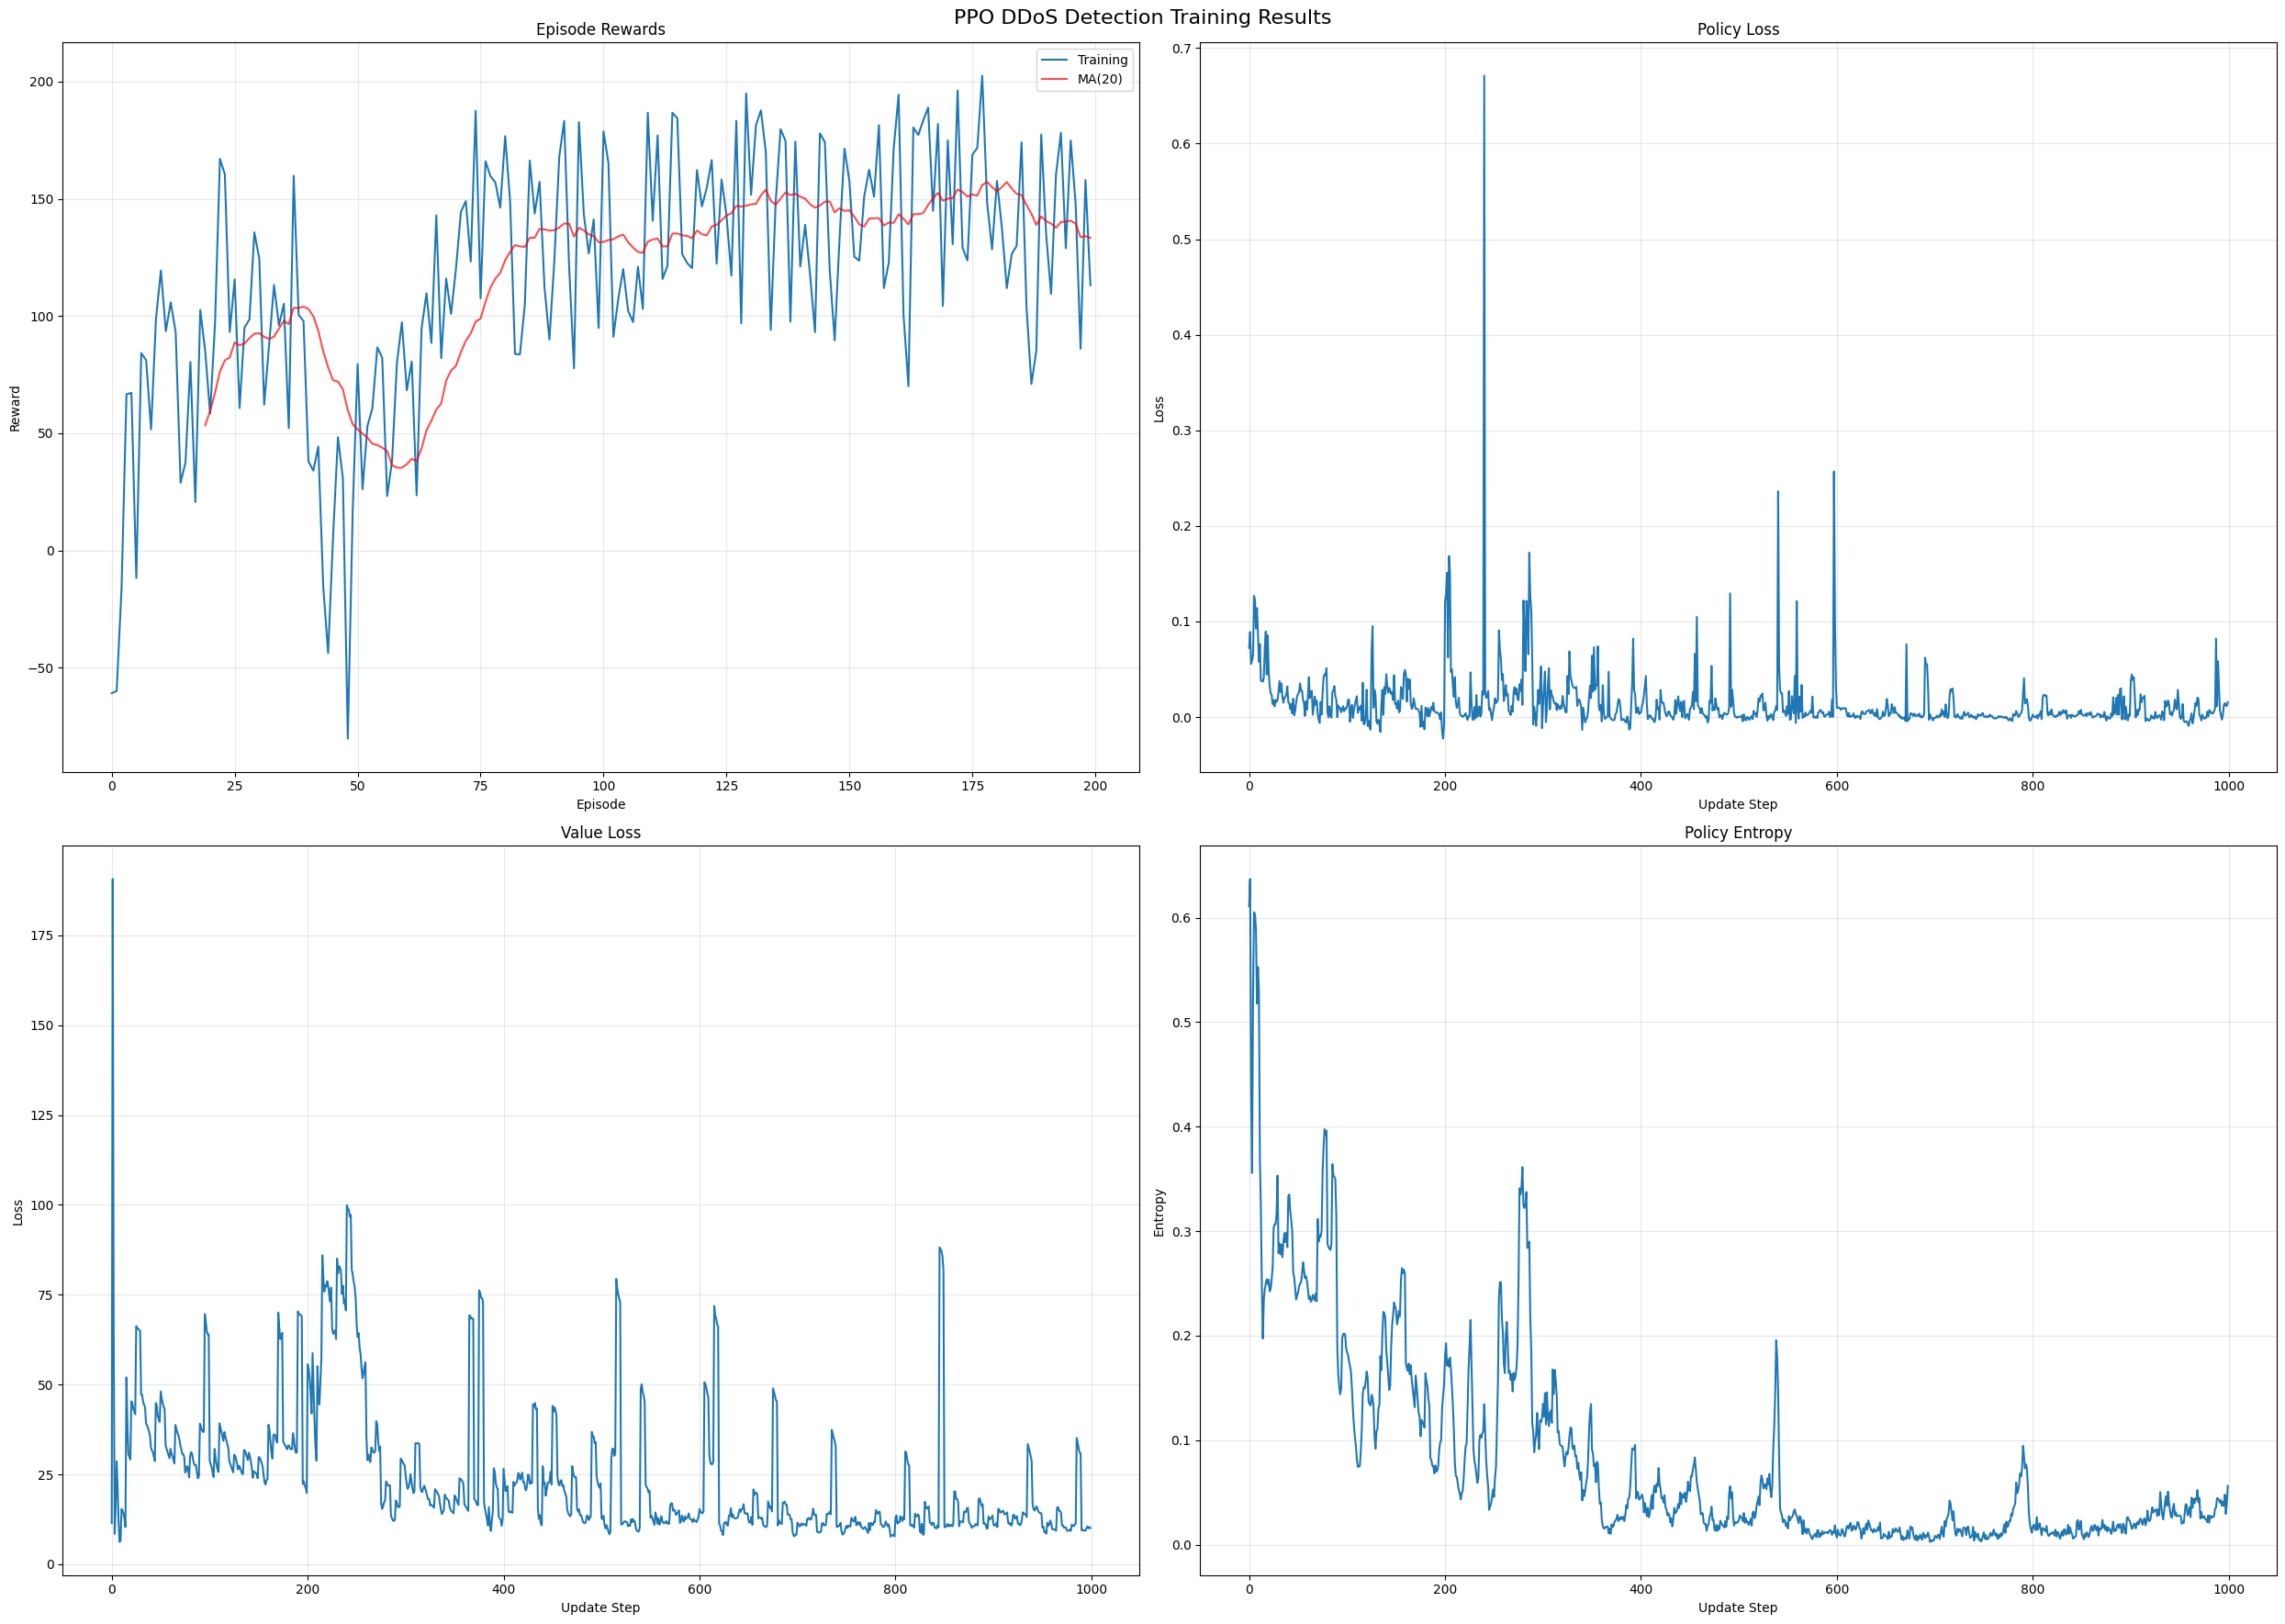

2025-09-07 21:22:36,573 - __main__ - INFO - Threshold plots saved to threshold_evolution.png


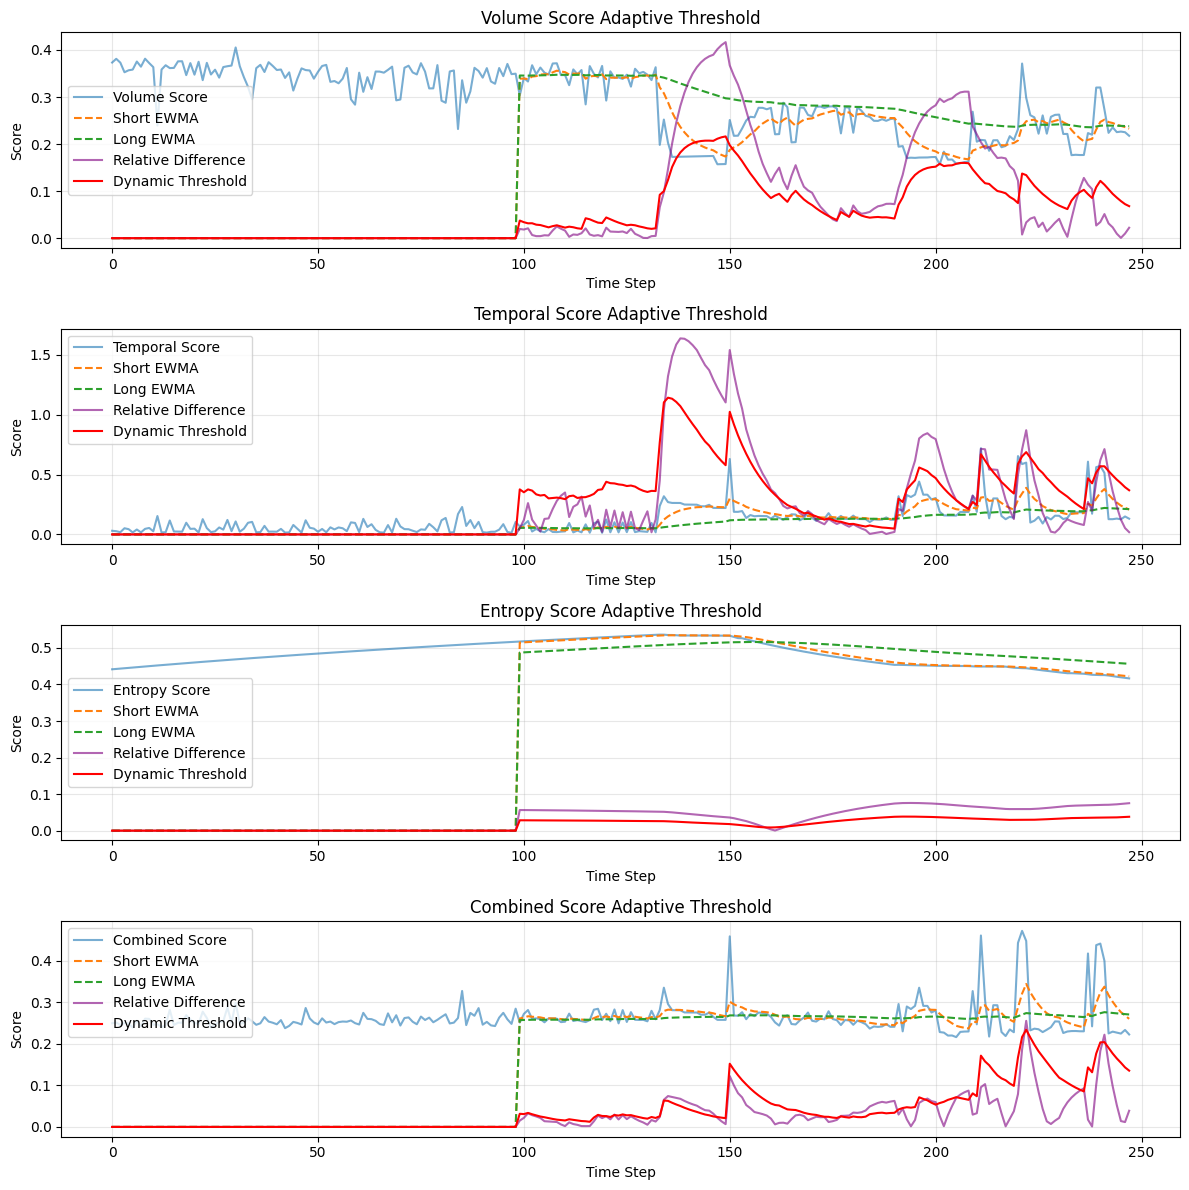

In [15]:
  # Example data

# Create environment
env = EnhancedDDoSEnvironment(df.values)

# Create and train agent (only needs flow feature dimension)
agent = EnhancedPPOAgent(FLOW_FEATURE_DIM, ACTION_DIM)
rewards = agent.train(env,max_episodes=200)




In [12]:
rewards

[-26.0,
 6.0,
 366.0,
 431.0,
 242.0,
 354.0,
 499.0,
 431.0,
 191.0,
 509.0,
 535.0,
 516.0,
 488.0,
 470.0,
 124.0,
 186.0,
 461.0,
 210.0,
 523.0,
 502.0,
 117.0,
 170.0,
 672.0,
 652.0,
 425.0,
 394.0,
 161.0,
 410.0,
 455.0,
 683.0,
 660.0,
 111.0,
 508.0,
 560.0,
 524.0,
 486.0,
 257.0,
 672.0,
 466.0,
 135.0,
 130.0,
 639.0,
 581.0,
 215.0,
 394.0,
 339.0,
 543.0,
 580.0,
 269.0,
 592.0,
 573.0,
 213.0,
 418.0,
 270.0,
 557.0,
 506.0,
 347.0,
 275.0,
 186.0,
 301.0,
 115.0,
 425.0,
 108.0,
 355.0,
 344.0,
 103.0,
 669.0,
 280.0,
 329.0,
 165.0,
 439.0,
 624.0,
 516.0,
 494.0,
 595.0,
 434.0,
 562.0,
 538.0,
 604.0,
 602.0,
 643.0,
 484.0,
 231.0,
 231.0,
 46.0,
 554.0,
 499.0,
 575.0,
 404.0,
 160.0,
 544.0,
 589.0,
 631.0,
 344.0,
 222.0,
 587.0,
 441.0,
 286.0,
 619.0,
 71.0,
 578.0,
 563.0,
 74.0,
 422.0,
 305.0,
 200.0,
 249.0,
 297.0,
 379.0,
 509.0,
 457.0,
 514.0,
 96.0,
 129.0,
 661.0,
 553.0,
 165.0,
 81.0,
 138.0,
 494.0,
 433.0,
 489.0,
 589.0,
 483.0,
 495.0,
 406.0,

In [6]:
agent.save_model("final_drl11.pt")`

2025-09-06 20:31:22,510 - __main__ - INFO - Model successfully saved to final_drl11.pt
2025-09-06 20:31:22,510 - __main__ - INFO - Saved from Windows on cuda:0


True

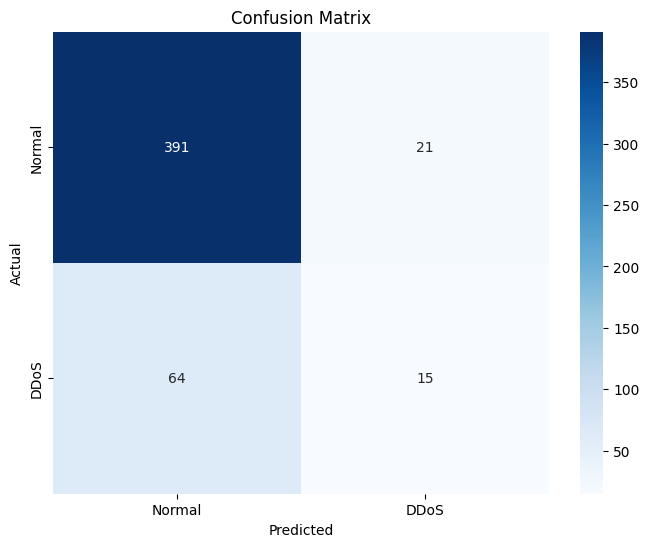

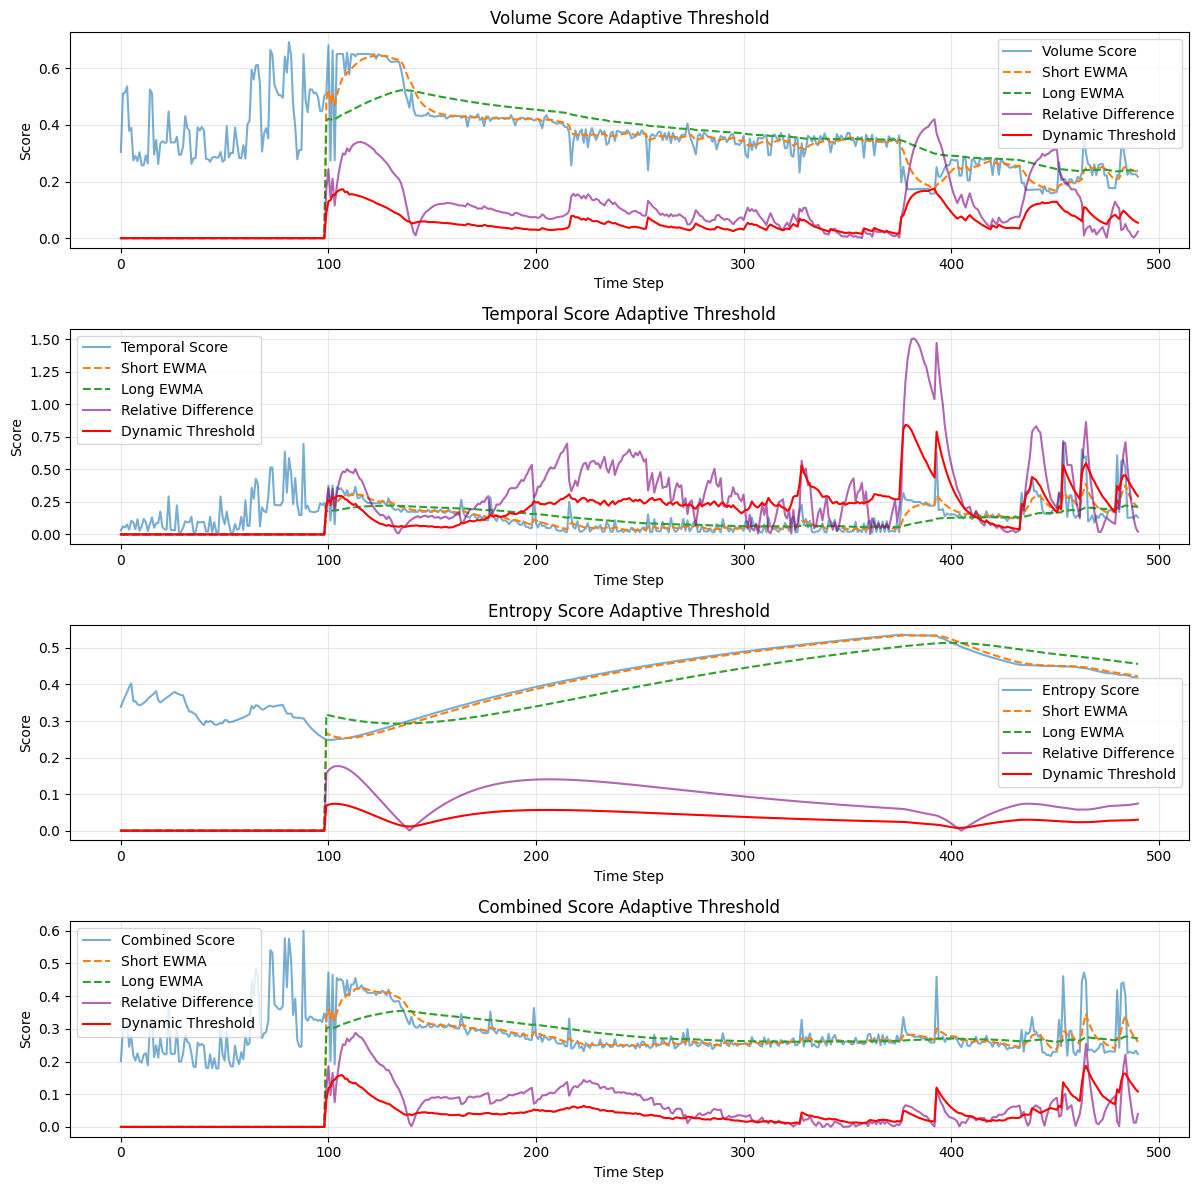

In [11]:
env.plot_confusion_matrix()  # Shows current confusion matrix
env.threshold_detector.plot_thresholds()  # Shows threshold adaptation over time

2025-09-02 15:45:42,719 - __main__ - INFO - Episode 0: Reward = -1567.00, Steps = 981
2025-09-02 15:45:47,499 - __main__ - INFO - Episode 1: Reward = 332.00, Steps = 980
2025-09-02 15:45:51,754 - __main__ - INFO - Episode 2: Reward = 949.00, Steps = 904
2025-09-02 15:45:56,263 - __main__ - INFO - Episode 3: Reward = 989.00, Steps = 929
2025-09-02 15:46:00,815 - __main__ - INFO - Episode 4: Reward = 1045.00, Steps = 948
2025-09-02 15:46:05,484 - __main__ - INFO - Episode 5: Reward = -1660.00, Steps = 967
2025-09-02 15:46:10,092 - __main__ - INFO - Episode 6: Reward = 953.00, Steps = 960
2025-09-02 15:46:14,725 - __main__ - INFO - Episode 7: Reward = 953.00, Steps = 961
2025-09-02 15:46:19,097 - __main__ - INFO - Episode 8: Reward = 948.00, Steps = 918
2025-09-02 15:46:23,980 - __main__ - INFO - Episode 9: Reward = -1863.00, Steps = 999
2025-09-02 15:46:23,981 - __main__ - INFO - Evaluation - Average reward: 107.900 ± 1198.396
2025-09-02 15:46:23,981 - __main__ - INFO - Action distributi

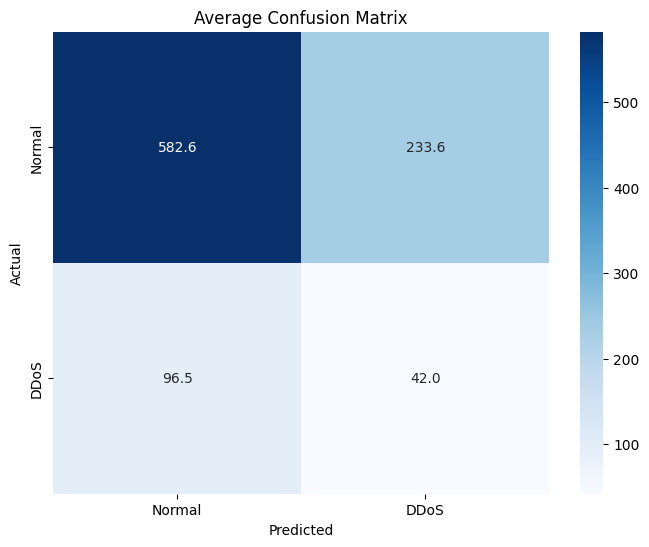

In [22]:
avg_reward, action_counts, episode_rewards = agent.evaluate(env,10,10000)

In [23]:
agent = EnhancedPPOAgent(FLOW_FEATURE_DIM, ACTION_DIM)

2025-09-02 15:46:56,992 - __main__ - INFO - Using device: cuda


In [24]:
model =agent.load_model("final_drl1.pt")



2025-09-02 15:46:57,953 - __main__ - INFO - Loading model saved on Windows to Windows
2025-09-02 15:46:57,954 - __main__ - INFO - Using device: cuda
2025-09-02 15:46:57,967 - __main__ - INFO - Optimizer state loaded successfully
2025-09-02 15:46:57,967 - __main__ - INFO - Scheduler state loaded successfully
2025-09-02 15:46:57,968 - __main__ - INFO - Model successfully loaded from final_drl1.pt to cuda


In [25]:
csv_path = "input_data.csv"       # edit path
df   = pd.read_csv(csv_path,low_memory=False)

df.columns =df.columns.str.strip()
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaNs with column mean or 0
df.fillna(df.mean(), inplace=True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# # Fit the scaler on training data and transform both train and test
data = scaler.fit_transform(df)
df2 = pd.DataFrame(data,columns=flow_features.columns)


In [26]:
results=agent.predict_batch(df)